## 06. 피마 인디언 당뇨병 예측

피마 인디언 당뇨병 데이터 세트 구성 살펴보기  
- Pregnancies: 임신횟수  
- Glucose: 포도당 부하 검사 수치  
- BloodPressure: 혈압  
- SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값  
- Insulin: 혈청 인슐린  
- BMI: 체질량 지수  
- DiabetesPedigreeFunction : 당뇨 내력 가중치 값  
- Age: 나이   
- Outcome: 당뇨여부(0 또는 1)  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler, Binarizer
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
# 데이터 불러오기
diabetes_data = pd.read_csv('../data/pima-indians/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


- 전체 768개의 데이터 중, Negative 값 0이 500개, Positive 값 1이 268개

In [3]:
# feature 타입과 Null 개수 세어보기
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


- Null 값은 없으며 피처 타입은 모두 숫자형  

**-** 로지스틱 회귀를 이용해 예측 모델 생성하기

In [4]:
# 평가지표 출력하는 함수 설정
def get_clf_eval(y_test, y_pred):
    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)
    AUC = roc_auc_score(y_test, y_pred)
    
    print('오차행렬:\n', confusion)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('F1: {:.4f}'.format(F1))
    print('AUC: {:.4f}'.format(AUC))

In [5]:
# Precision-Recall Curve Plot 그리기
def precision_recall_curve_plot(y_test, pred_proba):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba)
    
    # x축을 threshold, y축을 정밀도, 재현율로 그래프 그리기
    plt.figure(figsize=(8, 6))
    thresholds_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[:thresholds_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[:thresholds_boundary], linestyle=':', label='recall')
    
    # threshold의 값 X축의 scale을 0.1 단위로 변경
    stard, end = plt.xlim()
    plt.xticks(np.round(np.arange(stard, end, 0.1), 2))
    
    plt.xlim()
    plt.xlabel('thresholds')
    plt.ylabel('precision & recall value')
    plt.legend()
    plt.grid()

In [6]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y 추출
# 맨 끝이 Outcome 칼럼으로 레이블 값, 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[88 12]
 [23 31]]

정확도: 0.7727
정밀도: 0.7209
재현율: 0.5741
F1: 0.6392
AUC: 0.7270


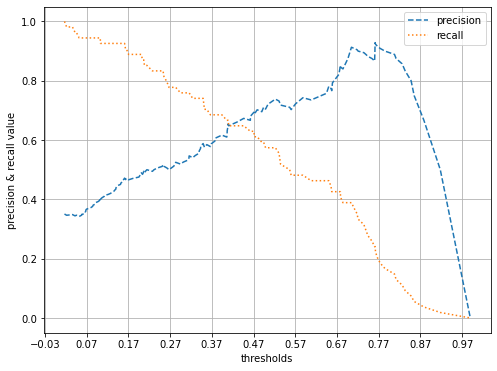

In [7]:
# 임계값별로 정밀도 - 재현율 출력
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba)

- 재현율 곡선을 보면 임계값을 0.42 정도로 낮추면 정밀도와 재현율이 어느 정도 균형을 맞출 것  
  그러나, 두 지표 모두 0.7이 되지 않는 수치  


**-** 임계값을 인위 조작하기 전에 다시 데이터 점검해보기

In [8]:
# 원본 데이터 DataFrane describe() 메서드로 피처 값의 분포도 살피기
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


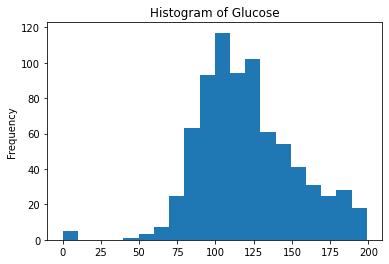

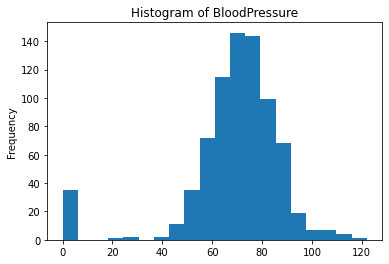

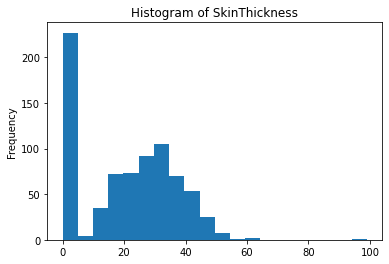

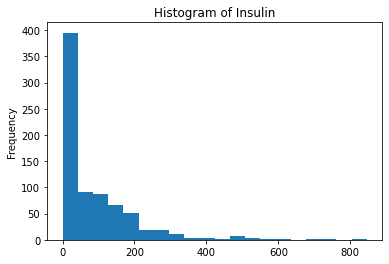

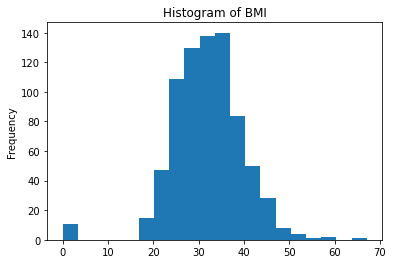

In [9]:
# min() 값이 0으로 된 피처에 대해 0 값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인해보기
feature_list = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

def hist_plot(df):
    for col in feature_list:
        df[col].plot(kind='hist', bins=20).set_title('Histogram of '+col)
        plt.show()

hist_plot(diabetes_data)

- SkinThickness와 Insulin의 0 값은 전체의 29.56%, 48.7%로 많은 수준  

**-** 일괄 삭제 대신 위 피처의 0 값을 평균값으로 대체

In [10]:
# 위 컬럼들에 대한 0 값의 비율 확인
zero_count = []
zero_percent = []
for col in feature_list:
    zero_num = diabetes_data[diabetes_data[col]==0].shape[0]
    zero_count.append(zero_num)
    zero_percent.append(np.round(zero_num/diabetes_data.shape[0]*100,2))

zero = pd.DataFrame([zero_count, zero_percent], columns=feature_list, index=['count', 'percent']).T
zero

,count,percent
Glucose,5.0,0.65
BloodPressure,35.0,4.56
SkinThickness,227.0,29.56
Insulin,374.0,48.70
BMI,11.0,1.43


In [11]:
# zero_features 리스트 내부 저장된 개별 피처의 0 값을 NaN 값으로 대체
diabetes_data[feature_list] = diabetes_data[feature_list].replace(0, np.nan)

# 위 5개 feature 에 대해 0값을 평균 값으로 대체
mean_features = diabetes_data[feature_list].mean()
diabetes_data[feature_list] = diabetes_data[feature_list].replace(np.nan, mean_features)

In [12]:
# 데이터 세트에 피처 스케일링을 적용해 변환하기
# 로지스틱 회귀의 경우, 숫자 데이터에 스케일링을 적용하는 것이 일반적으로 성능이 좋음
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 상용하여 데이터 세트에 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state=156, stratify = y)

# 로지스틱 회귀로 학습, 예측, 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train,  y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬:
 [[89 11]
 [21 33]]

정확도: 0.7922
정밀도: 0.7500
재현율: 0.6111
F1: 0.6735
AUC: 0.7506


In [13]:
# 평가지표를 조사하기 위한 새로운 함수 생성
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('\n임계값: ', custom_threshold)
        get_clf_eval(y_test, custom_predict)

- 데이터 변환과 스케일링으로 성능 수치가 일정 수준 개선  
  하지만, 여전히 재현율 수치 개선이 필요함
  
**-** 분류 결정 임계값을 변화시키면서 재현율 값의 성능 수치 개선 정도를 확인하기

In [14]:
# 임계값을 0.3에서 0.5까지 0.03씩 변화시키면서 재현율과 다른 평가 지표의 값 변화를 출력
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1, 1), thresholds)


임계값:  0.3
오차행렬:
 [[68 32]
 [10 44]]

정확도: 0.7273
정밀도: 0.5789
재현율: 0.8148
F1: 0.6769
AUC: 0.7474

임계값:  0.33
오차행렬:
 [[74 26]
 [11 43]]

정확도: 0.7597
정밀도: 0.6232
재현율: 0.7963
F1: 0.6992
AUC: 0.7681

임계값:  0.36
오차행렬:
 [[75 25]
 [13 41]]

정확도: 0.7532
정밀도: 0.6212
재현율: 0.7593
F1: 0.6833
AUC: 0.7546

임계값:  0.39
오차행렬:
 [[82 18]
 [16 38]]

정확도: 0.7792
정밀도: 0.6786
재현율: 0.7037
F1: 0.6909
AUC: 0.7619

임계값:  0.42
오차행렬:
 [[85 15]
 [18 36]]

정확도: 0.7857
정밀도: 0.7059
재현율: 0.6667
F1: 0.6857
AUC: 0.7583

임계값:  0.45
오차행렬:
 [[86 14]
 [19 35]]

정확도: 0.7857
정밀도: 0.7143
재현율: 0.6481
F1: 0.6796
AUC: 0.7541

임계값:  0.48
오차행렬:
 [[88 12]
 [20 34]]

정확도: 0.7922
정밀도: 0.7391
재현율: 0.6296
F1: 0.6800
AUC: 0.7548

임계값:  0.5
오차행렬:
 [[89 11]
 [21 33]]

정확도: 0.7922
정밀도: 0.7500
재현율: 0.6111
F1: 0.6735
AUC: 0.7506


- 0.33: 정확도와 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임계값  
- 0.48: 전체적인 성능 평가 지표를 유지하며 재현율을 약간 향상시키는 좋은 임계값  


**-** 앞서 학습된 로지스틱 회귀 모델을 이용해 임계값을 0.48로 낮춘 상태에서 다시 예측하기

In [15]:
# 임계값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환하기
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1, 1))

get_clf_eval(y_test, pred_th_048)

오차행렬:
 [[88 12]
 [20 34]]

정확도: 0.7922
정밀도: 0.7391
재현율: 0.6296
F1: 0.6800
AUC: 0.7548
